# Val and Marta's Final Project
## CSE360/460

### Frisbee-Catching Robot

In [1]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [68]:
class robot():
            
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    

In [69]:
# For finding the coefficients for splines, in order to move the frisbee
def point_to_point_traj(x1, x2, v1, v2, delta_t):
    # the following is finding each coefficient for the spline
    a0 = x1
    a1 = v1
    a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
    a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)
    return a0, a1, a2, a3


In [ ]:
import sim as vrep
import time
import cv2
import numpy as np
from random import * # for random numbers
vrep.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

r = robot('Quadricopter_target')
# Move the frisbee
disc = robot('Sphere')

# Create trajectory for disc 
random_num = 0
#randint(0, 2)  # pick a number between 0 and 2

# TODO: Fix trajectories to be what we want (can be done anytime)
if random_num == 0:
    x_i, x_f, vx_i, vx_f = 0.5, 1.2, 0, 0
    y_i, y_f, vy_i, vy_f = 5.5, -4.4, 0, 0
    z_i, z_f, vz_i, vz_f = 1.5, 3, 0, 0
elif random_num == 1:
    x_i, x_f, vx_i, vx_f = 0, 0, 0, 0
    y_i, y_f, vy_i, vy_f = 0, 0, 0, 0
    z_i, z_f, vz_i, vz_f = 0, 0, 0, 0
elif random_num == 2:
    x_i, x_f, vx_i, vx_f = 0, 0, 0, 0
    y_i, y_f, vy_i, vy_f = 0, 0, 0, 0
    z_i, z_f, vz_i, vz_f = 0, 0, 0, 0
    
a0x, a1x, a2x, a3x = point_to_point_traj(x_i, x_f, vx_i, vx_f, 20)
a0y, a1y, a2y, a3y = point_to_point_traj(y_i, y_f, vy_i, vy_f, 20)
a0z, a1z, a2z, a3z = point_to_point_traj(z_i, z_f, vz_i, vz_f, 20)

# Time interval
time_steps = linspace(0, 20, 201)

res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
orientations = []
images = []
s = 0

for t in time_steps:
    tx, ty, tz = a0x + a1x * t + a2x * t**2 + a3x * t**3, a0y + a1y * t + a2y * t**2 + a3y * t**3, a0z + a1z * t + a2z * t**2 + a3z * t**3
    disc.set_position([tx, ty, tz])
    disp(t)
    if s%2 == 0 :
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        orientation = vrep.simxGetObjectOrientation(clientID, v1, -1, vrep.simx_opmode_blocking)[1][1]
        orientations.append(orientation)
        if err == vrep.simx_return_ok:
            print ("image OK!!!")
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            images.append(img)
            imshow(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray,5)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=30,param2=15,minRadius=0,maxRadius=0)
        center = (circle[0], circle[1])  # In pixels
        radius = circle[2]  # In pixels
        # Plot center
        u0, v0 = 132, 132
        k = radius / (0.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
        fov = 60  # degrees

        # number of pixels in x-axis
        npx = 264

        # maximum value in the x-axis (in meters)
        xmax = npx / (2.* k)

        # Distance to the center of the sphere (z-axis coordinate)
        zc = xmax / tan(pi/6)

        # Location of the sphere in the x-axis coordinate
        xc = ((center[0] - u0) / k)
        
        if xc > 0.1:
            r.send_motor_velocities([4,0,0])
        elif xc < -0.1:
            r.send_motor_velocities([-4,0,0])
        
    time.sleep(0.1)
    s = s + 1
imshow(images[0])


Robot connected
Robot connected
0.0
0.1
0.2
image OK!!!
0.30000000000000004
0.4
image OK!!!
0.5
0.6000000000000001
image OK!!!
0.7000000000000001
0.8
image OK!!!
0.9
1.0
image OK!!!
1.1
1.2000000000000002
image OK!!!
1.3
1.4000000000000001
image OK!!!
1.5
1.6
image OK!!!
1.7000000000000002
1.8
image OK!!!
1.9000000000000001
2.0
image OK!!!
2.1
2.2
image OK!!!
2.3000000000000003
2.4000000000000004
image OK!!!
2.5
2.6
image OK!!!
2.7
2.8000000000000003
image OK!!!
2.9000000000000004
3.0
image OK!!!
3.1
3.2
image OK!!!
3.3000000000000003
3.4000000000000004
image OK!!!
3.5
3.6
image OK!!!
3.7
3.8000000000000003
image OK!!!
3.9000000000000004
4.0
image OK!!!
4.1000000000000005
4.2
image OK!!!
4.3
4.4
image OK!!!
4.5
4.6000000000000005
image OK!!!
4.7
4.800000000000001
image OK!!!
4.9
5.0
image OK!!!
5.1000000000000005
5.2
image OK!!!
5.300000000000001
5.4
image OK!!!
5.5
5.6000000000000005
image OK!!!
5.7
5.800000000000001
image OK!!!
5.9
6.0
image OK!!!
6.1000000000000005
6.2
image OK!!!
6

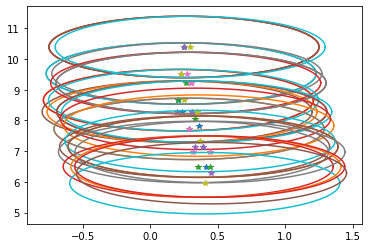

In [78]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

new_centers = []
circles_array = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=30,param2=15,minRadius=0,maxRadius=0)
    circles_array.append(circles)
    
i = -1
for circles in circles_array:
    i = i + 1
    # for every circle we find it in our pov and plot it
    if circles is not None:
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # In pixels
            radius = circle[2]  # In pixels
            # Plot center
            u0, v0 = 132, 132
            k = radius / (0.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
            fov = 60  # degrees

            # number of pixels in x-axis
            npx = 264

            # maximum value in the x-axis (in meters)
            xmax = npx / (2.* k)

            # Distance to the center of the sphere (z-axis coordinate)
            zc = xmax / tan(pi/6)

            # Location of the sphere in the x-axis coordinate
            xc = ((center[0] - u0) / k)
  
            plot(xc, zc, '*')
            
            # plot the transformed circles
            s = linspace(0,2*pi,100)
            cx = cos(s) + xc
            cy = sin(s) + zc
            plot(cx, cy)
            new_centers.append([xc, zc])
